# Train mini-ML model on 3d pose points

Train a random forest. 

Ideas:
* add age as feature to CSV -> this could be used as a feature in training(but introduces bias)

Learnings: 
* it helps to have 3D-components of bone vectors
* it helps to only keep the important bones
* confidence and validity do not help training a RF

Future work:
* Improve by median prediction of multiple artifacts
* make more robust: small model = few params
* XGboost
* try simple linear regression, select best features
* data augmentation

## Setup

In [83]:
# !pip install openmesh==1.1.6 threevis==0.1.0.post25

In [84]:
%reload_ext autoreload
%autoreload 2

from joblib import dump, load
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

REPO_DIR = Path(os.getcwd()).parents[5]
sys.path.append(str(REPO_DIR))

from constants import SKELETON_CGM
from train_util import get_artifact_id_from_path, get_features_from_fpath, plot_history, get_path_from_artifact_id, prepare_df, get_joints_from_fpath
from qa_config_pose3dpoints import RESULT_CONFIG, DATA_CONFIG
from config_train import CONFIG_TRAIN

from cgmml.common.evaluation.eval_utils import calculate_performance, calculate_performance_mae_artifact
from cgmml.common.evaluation.eval_utilities import calculate_and_save_results
from cgmml.common.evaluation.CV.evaluation import MINIMUM_CHILD_HEIGHT_IN_CM, MAXIMUM_CHILD_HEIGHT_IN_CM

In [85]:
DATA_DIR = REPO_DIR / 'data'
DATASET_DIR = REPO_DIR / 'data/datasets/pose3dpoints-dataset'; DATASET_DIR
NUM_ARTIFACTS_TO_SHOW = 3

INTERESTING_COLUMNS = ['height', 'weight', 'muac', 'scantype', 'abs_error']

# Eval
USE_FILTER_LOW_QUALITY_ARTIFACT = True

In [86]:
# import warnings
# warnings.filterwarnings('ignore')

## Create dataset split

In [87]:
SHOULD_CREATE_DATASET_SPLIT = False
if SHOULD_CREATE_DATASET_SPLIT:
    df = pd.read_csv(DATASET_DIR / 'metadata.csv')

    # Split
    scan_id_series = df.scan_id.unique()
    train_set_tmp, test_set = train_test_split(scan_id_series, test_size=0.1, random_state=1)
    train_set, val_set = train_test_split(train_set_tmp, test_size=0.1, random_state=1)

    print('Unique scan_ids:', scan_id_series.shape)
    print('Unique Train/val/test scans:', train_set.shape, val_set.shape, test_set.shape)

    # Create new dataframe column and fill according to the split
    df.loc[:, 'dset_split'] = np.NaN
    df.loc[df.scan_id.isin(train_set), 'dset_split'] = 'train'
    df.loc[df.scan_id.isin(val_set), 'dset_split'] = 'val'
    df.loc[df.scan_id.isin(test_set), 'dset_split'] = 'test'

    print('Train/val/test artifacts:', df[df['dset_split'] == 'train'].shape, df[df['dset_split'] == 'val'].shape, df[df['dset_split'] == 'test'].shape)
    assert np.all(df['dset_split'].isin(['train', 'val', 'test']))

    df.to_csv(DATASET_DIR / 'metadata_with_dset_split.csv')
    del df

In [88]:
df_ = pd.read_csv(DATASET_DIR / 'metadata_with_dset_split.csv')
df_.rename(columns={"scan_type": "scantype"}, inplace=True)
df_ = df_.astype({'scantype': 'str'})
artifact_ids_all = list(df_['artifact_id'])

In [89]:
# Get artifacts obj file names from data dir
obj_files_paths_ = list(sorted(DATASET_DIR.glob('*.obj')))
obj_files_names_all = [get_artifact_id_from_path(path) for path in obj_files_paths_]

In [90]:
# Show that the CSV has more files than we have artifacts
x = set(artifact_ids_all)
y = set(obj_files_names_all)
z = x.intersection(y)
len(x), len(y), len(z)

(27919, 6898, 6898)

In [91]:
# Only keep the rows for which we have artifacts
df_all = df_[df_.artifact_id.isin(obj_files_names_all)]

# Sort dataframe by artifact_id
df_all = df_all.set_index('artifact_id')
df_all = df_all.sort_index()

# Make sure that file names are in the same order as the dataframe
assert np.all(obj_files_names_all == df_all.index)

df_all.shape, len(obj_files_names_all)

((6898, 13), 6898)

In [92]:
# Filter by scan type
df = df_all[df_all.scantype.isin(CONFIG_TRAIN.SCAN_TYPES_TO_USE)]
artifact_ids = list(df.index)

obj_files_names = [name for name in obj_files_names_all if name in artifact_ids]
obj_files_paths = [get_path_from_artifact_id(name, DATASET_DIR) for name in obj_files_names]

print(df.shape, len(obj_files_paths))
df.head()

(3035, 13) 3035


,Unnamed: 0,scan_id,order,depthmap_path,rgb_path,height,weight,muac,scan_version,scantype,measurement_date,scan_date,dset_split
artifact_id,,,,,,,,,,,,,
0816b862-8e1b-11eb-941c-dbaed44346b6,262,0816b860-8e1b-11eb-941c-ab8a1eff68ab,1.0,1616726354112/3428cc7a-002f-45ee-82f8-c4618ce8...,1616726346829/27fd9dca-694c-4593-b464-bb767f30...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train
08183f00-8e1b-11eb-941c-cf2a8c1b927f,263,0816b860-8e1b-11eb-941c-ab8a1eff68ab,2.0,1616726354229/a1a926f5-a9eb-40d2-ab11-60e2fb7a...,1616726354149/39af2c90-d6d6-4bab-bcf8-33320a2c...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train
08183f02-8e1b-11eb-941c-9b7184a99229,255,0816b860-8e1b-11eb-941c-ab8a1eff68ab,3.0,1616726354264/8a3d2cec-b395-4c44-a29e-323164e2...,1616726354194/ee2cf646-503a-4137-bc45-d9db5e4c...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train
08183f04-8e1b-11eb-941c-a3304ecd1294,256,0816b860-8e1b-11eb-941c-ab8a1eff68ab,4.0,1616726360883/c1dd0daa-f682-4129-a11a-50735d20...,1616726361201/126b2218-34cb-4c80-97bc-c68ece9b...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train
08183f06-8e1b-11eb-941c-6b69cb6bd4f4,257,0816b860-8e1b-11eb-941c-ab8a1eff68ab,5.0,1616726364111/587634dc-69d5-425b-9b1f-91c2ac1e...,1616726364587/5ccdb1e7-2c09-4c5e-80f4-aa5779dd...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train


In [93]:
# Make sure that file names are in the same order as the dataframe
assert np.all(obj_files_names == df.index)

# df and obj_files_names are now prepared!

## Feature engineering

In [94]:
# Create columns by looking at first child's features
obj_file_path = obj_files_paths[0]
child_features = get_features_from_fpath(obj_file_path, config_train=CONFIG_TRAIN)

num_samples = len(obj_files_paths); print(num_samples)
num_features = len(child_features); print(num_features)

3035
46


In [95]:
# Check features of 1 child
# child_features

In [96]:
features_array = np.empty([num_samples, num_features])
features_array[:] = np.NaN

for artifact_index, obj_file_path in enumerate(obj_files_paths):
    child_features = get_features_from_fpath(obj_file_path, config_train=CONFIG_TRAIN)
    features_array[artifact_index] = np.array(list(child_features.values()))
assert np.all(~np.isnan(features_array))  # Check all features were calculated
features_array.shape

(3035, 46)

In [97]:
features_array.shape, df.shape

((3035, 46), (3035, 13))

In [98]:
# Split train, eval, test set according to df

X = features_array

# We can assume that X and df are in the same order

df_train = df[df['dset_split'] == 'train']
df_val = df[df['dset_split'] == 'val']
df_test = df[df['dset_split'] == 'test']

y_train = df_train.height
y_val = df_val.height
y_test = df_test.height

X_train = X[np.where(df['dset_split'] == 'train')]
X_val = X[np.where(df['dset_split'] == 'val')]
X_test = X[np.where(df['dset_split'] == 'test')]
# df_train.shape, X_train.shape

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2563, 46) (2563,)
(211, 46) (211,)
(261, 46) (261,)


In [122]:
df_val.scan_id.unique().shape

(16,)

## Mean Baseline

In [99]:
# Mean baseline
y_true = y_test
height_mean = df.height.mean()
y_pred = [height_mean for _ in range(X_test.shape[0])]
mean_absolute_error(y_true, y_pred)

7.343219779456785

## Random Forest

In [100]:
regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0)
regr.fit(X_train, y_train);

In [101]:
# Evaluate
y_true = df_val.height
y_pred = regr.predict(X_val)
mean_absolute_error(y_true, y_pred)

1.2726676774871168

In [102]:
# Save model
model_name = f'2021q4-points3d-rf-height-28k-{"and".join(CONFIG_TRAIN.SCAN_TYPES_TO_USE)}'
MODEL_PATH = DATA_DIR / f'models/pose3dpointsModel/{model_name}.joblib'
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
dump(regr, MODEL_PATH)
regr = load(MODEL_PATH)

In [103]:
# Check the predicted height is realistic

if USE_FILTER_LOW_QUALITY_ARTIFACT:
    y_pred = regr.predict(X_val)
    print('amount of all samples:', y_pred.shape[0])
    indexes = np.where((MINIMUM_CHILD_HEIGHT_IN_CM < y_pred) & (y_pred < MAXIMUM_CHILD_HEIGHT_IN_CM))[0]
    print('amount of sane samples:', indexes.shape[0])
    
    y_pred_ = y_pred[indexes]
    y_true_ = df_val.height.iloc[indexes]
    
    mae = mean_absolute_error(y_true_, y_pred_)
    print(f'mae (filtered): {mae:.2f}')

amount of all samples: 211
amount of sane samples: 211
mae (filtered): 1.27


In [104]:
# Evaluate per scan step
for scantype in DATA_CONFIG.CODES:
    indexes = np.where(df_val.scantype == scantype)[0]
    y_true_ = df_val.iloc[indexes].height
    if not X_val[indexes].any():
        continue
    y_pred_ = regr.predict(X_val[indexes])
    mae = mean_absolute_error(y_true_, y_pred_)
    print(f'{scantype}: {mae:.2f}')
    

200: 1.18
201: 1.37


In [105]:
df_val.loc[:, 'GT'] = df_val['height']
df_val.loc[:, 'predicted'] = y_pred
df_val.loc[:, 'error'] = df_val['GT'] - df_val['predicted']

csv_fpath = REPO_DIR / 'data/outputs/pose3dpointmodel/test_mae_artifact_level_pose3dpointmodel.csv'
calculate_and_save_results(df_val.copy(), 'pose3dpointmodel', csv_fpath,
                           DATA_CONFIG, RESULT_CONFIG, fct=calculate_performance_mae_artifact)

/Users/markus/Development/cgm/cgm-ml/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/markus/Development/cgm/cgm-ml/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [106]:
df_val_grouped = prepare_df(df_val.copy())
csv_out_fpath = REPO_DIR / 'data/outputs/pose3dpointmodel/pose3dpointmodel.csv'
calculate_and_save_results(df_val_grouped, 'pose3dpointmodel', csv_out_fpath, DATA_CONFIG, RESULT_CONFIG, fct=calculate_performance)

In [107]:
df_val.loc[:, 'abs_error'] = np.abs(df_val['error'])

(-3.0, 3.0)

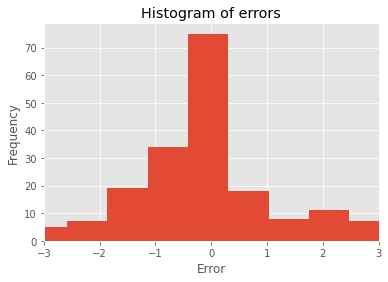

In [108]:
df_val['error'].hist(bins=20);
plt.ylabel('Frequency'); plt.xlabel('Error'); plt.title('Histogram of errors');
plt.xlim(-3, 3)

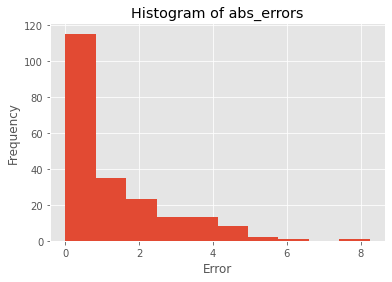

In [109]:
df_val['abs_error'].hist();
plt.ylabel('Frequency'); plt.xlabel('Error'); plt.title('Histogram of abs_errors');

In [110]:
# Sort by error
df_errors = df_val.sort_values('abs_error', ascending=False)

In [111]:
# Show some results
# for i in range(20):
#     pred = regr.predict([X_test[i]])
#     print(pred[0], 'actual:', y_test[i])

## Neural Network

In [112]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))

2021-10-25 10:20:53.788130: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-25 10:20:53.794177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [113]:
# hyperparameters
model = models.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="linear")
])
LR = 0.003
BATCH_SIZE = 16

# Training code
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LR)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# checkpoint
MODEL_CKPT_FILENAME = "best_model.ckpt"
best_model_path = str(DATA_DIR / f'models/pose3dpointsModel/outputs/{MODEL_CKPT_FILENAME}')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=-1
)

history = model.fit(
    dataset_train.repeat(5).batch(BATCH_SIZE),
    validation_data=dataset_validation.batch(BATCH_SIZE),
    epochs=60,
    verbose=2,
    callbacks=[checkpoint_callback]
)

model = tf.keras.models.load_model(best_model_path)
loss, mae = model.evaluate(dataset_train.batch(BATCH_SIZE))
val_loss, val_mae = model.evaluate(dataset_validation.batch(BATCH_SIZE))
print(f'mae: {mae}, val_mae: {val_mae}')

Epoch 1/60


2021-10-25 10:20:55.548390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


801/801 - 2s - loss: 9710.9111 - mae: 15.6771 - val_loss: 303.6802 - val_mae: 16.6023


2021-10-25 10:20:57.007817: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 2/60
801/801 - 1s - loss: 138.6321 - mae: 5.5728 - val_loss: 189.7032 - val_mae: 12.8536
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 3/60
801/801 - 1s - loss: 229.7914 - mae: 5.1681 - val_loss: 105.3646 - val_mae: 9.0168
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 4/60
801/801 - 1s - loss: 359.1142 - mae: 4.9562 - val_loss: 73.8101 - val_mae: 7.2304
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 5/60
801/801 - 2s - loss: 81.6698 - mae: 4.3352 - val_loss: 83.1051 - val_mae: 7.7708
Epoch 6/60
801/801 - 2s - loss: 46.9886 - mae: 4.0133 - val_loss: 68.3543 - val_mae: 6.8525
IN

In [114]:
history

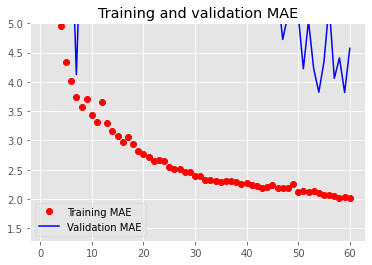

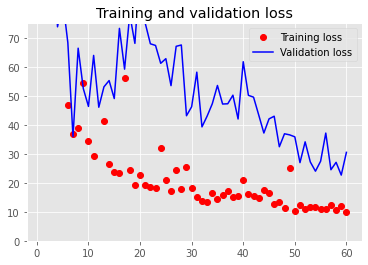

In [115]:
plot_history(history)

## Visualize good and bad predictions 

Visualization in 3D using [threevis](https://gitlab.vci.rwth-aachen.de:9000/threevis/threevis)

In [116]:
import threevis as tv
import openmesh as om

def draw_3d(mesh):
    ctx = tv.Context(width=320, height=240)  # width=640, height=480)  # Create Context
    vertices = mesh.points()  # Get vertices and faces from the mesh
    ctx.draw_edges(vertices, SKELETON_CGM)
    ctx.draw_vertices(vertices, point_size=4, colors='red')  # Draw a point for each vertex
    ctx.display()

In [117]:
# Show a sample visualization

m = om.read_trimesh(str(obj_files_paths[13]))
draw_3d(m)

/Users/markus/Development/cgm/cgm-ml/.venv/lib/python3.7/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

In [118]:
def draw_artifact(artifact_id):
    obj_file_path = get_path_from_artifact_id(artifact_id, DATASET_DIR)
    m = om.read_trimesh(str(obj_file_path))
    draw_3d(m)

    # print confidence values
    joints = get_joints_from_fpath(obj_file_path)
    confidences = [joint.confidence for joint in joints]
    print('mean confidence:', np.mean(confidences), 'confidences:', confidences)

In [119]:
# Worst predictions
for artifact_id, row in df_errors[INTERESTING_COLUMNS].head(NUM_ARTIFACTS_TO_SHOW).iterrows():
    print(row)
    draw_artifact(artifact_id)

height        81.1
weight        9.75
muac          13.6
scantype       201
abs_error    8.248
Name: 6bd84e06-8b04-11eb-8680-d7137ff75db9, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.854519726598964 confidences: [0.970772385597229, 0.9887139797210693, 0.9888868927955627, 0.884614884853363, 0.9448989033699036, 0.9619625210762024, 0.954894483089447, 0.9505710601806641, 0.9770322442054749, 0.9186299443244934, 0.9805018305778503, 0.7833201289176941, 0.7659270763397217, 0.555593729019165, 0.705024778842926, 0.429805189371109, 0.7656853199005127]
height        76.4
weight         8.5
muac          13.2
scantype       200
abs_error    6.192
Name: 9d66f4c0-8e20-11eb-8d18-f779d354cc17, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9523542698691873 confidences: [1.0430504083633423, 1.0125068426132202, 0.9733570218086243, 0.9455215930938721, 0.9493883848190308, 0.9940478205680847, 0.9771091938018799, 0.9614496827125549, 0.9850230813026428, 0.9575831294059753, 0.9631158113479614, 0.8577936291694641, 0.9325810670852661, 0.929253876209259, 0.93757164478302, 0.8658356070518494, 0.9048337936401367]
height        76.4
weight         8.5
muac          13.2
scantype       200
abs_error    5.562
Name: 9d656e26-8e20-11eb-8d18-1bae59f961f8, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9561159856179181 confidences: [0.9695892333984375, 1.0035582780838013, 1.0092952251434326, 0.9391860365867615, 0.9556829333305359, 0.9916937351226807, 0.9254133701324463, 0.9344805479049683, 0.9980186223983765, 0.966457188129425, 0.9442930817604065, 0.9176232814788818, 0.9863498210906982, 1.0026806592941284, 0.9891457557678223, 0.9157575964927673, 0.8047463893890381]


In [120]:
# Best predictions
for artifact_id, row in df_errors[INTERESTING_COLUMNS].tail(NUM_ARTIFACTS_TO_SHOW).iterrows():
    print(row)
    draw_artifact(artifact_id)


height             77.2
weight              8.1
muac                 13
scantype            201
abs_error    0.00304604
Name: c69bf8a2-8e15-11eb-b846-ffe5009d883b, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9433741850011489 confidences: [0.9575921297073364, 1.0058975219726562, 0.9838200807571411, 0.7393370270729065, 0.9654699563980103, 0.9583858251571655, 0.9514905214309692, 0.9899737238883972, 1.0427802801132202, 0.9876376986503601, 0.992808997631073, 0.8984885215759277, 0.8621657490730286, 0.9638741612434387, 0.8888283371925354, 0.9089040160179138, 0.9399065971374512]
height             77.2
weight              8.1
muac                 13
scantype            201
abs_error    0.00237168
Name: c6a08c86-8e15-11eb-b846-9f62b1223654, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9554021568859324 confidences: [1.0041933059692383, 0.9760746955871582, 0.9874169826507568, 0.9380016326904297, 0.9640815258026123, 0.9653553366661072, 0.935215413570404, 1.0013490915298462, 0.9919470548629761, 0.9505961537361145, 0.9462020397186279, 0.8773744106292725, 0.8827165961265564, 0.9414920210838318, 0.944866955280304, 0.9432832598686218, 0.9916701912879944]
height              77.2
weight               8.1
muac                  13
scantype             201
abs_error    0.000628316
Name: c698eb64-8e15-11eb-b846-ab9e82fb56fb, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9458333394106697 confidences: [0.9796302914619446, 0.9875159859657288, 0.9627746343612671, 0.9029310941696167, 0.9560874700546265, 0.9446398615837097, 0.9739095568656921, 0.9433745741844177, 0.922878623008728, 0.9680574536323547, 0.9552554488182068, 0.9227353930473328, 0.8816676735877991, 0.93173748254776, 0.9529898166656494, 0.9392234683036804, 0.9537579417228699]
